# Klasifikacija mina i kamenja u sonar datasetu 

### Autori: Alen Andrašek, Monika Majstorović, Luka Valenta 

Ovaj notebook napravljen je za potrebe kolegija Strojno učenje na PMF-u Sveučilišta u Zagrebu kao realizacija projektnog zadatka u akademskoj godini 2017./2018. 

Mentori:
- Tomislav Šmuc, prof.
- Tomislav Lipić, asist.
- Matija Piškorec, asist.

Cilj ovog notebooka jest pokazati primjer metodologije pri odabiru modela, obradi podataka i općenito realizaciji projekta. Bit će koncipiran kao tutorijal za provedbu projekta "od nule" (tj. počevši od dataseta).

Dataset kojeg koristimo naziva se Connectionist Bench (Sonar, Mines vs. Rocks) Data Set (skraćeno: sonar dataset) i skinut je s UCI repozitorija za strojno učenje.

##  1. O datasetu

Koji problem rješavamo pomoću ovog dataseta?

U opisu sonar dataseta dostupnom na [ref] saznajemo da je za svaki uzorak u datasetu poznato radi li se o mini ili kamenu te da je zadatak klasifikacija podataka u te dvije skupine.
Dakle, radi se o **nadziranom učenju** i problemu **binarne klasifikacije**.

### Eksploratorna analiza

Svrha eksploratorne analize jest dobiti općeniti uvid i upoznati se s datasetom.

Iz [ref] saznajemo da dataset sadrži 208 podataka. Svaki od njih ima 60 značajki čije su vrijednosti između 0.0 i 1.0 te oznaku klase 'R' ili 'M' ovisno o tome pripada li podatak kamenu ili mini. Ukupno ima 111 podataka koji pripadaju minama i 97 koji pripadaju kamenju. Nema vrijednosti koje nedostaju.

Pokažimo kako bismo to ispitali koristeći pandas:

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [37]:
# Učitamo dataset i dodijelimo imena stupcima

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/undocumented/connectionist-bench/sonar/sonar.all-data"

colNames = []
for i in range(60):
    colNames.append(i+1)
colNames.append("Class")

sonar = pd.read_csv(url,names=colNames,header=None)
sonar.head()

,1,2,3,4,5,6,7,8,9,10,...,52,53,54,55,56,57,58,59,60,Class
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,R
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,R
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,R
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,R
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,R


In [38]:
print("Dataframe ima",sonar.shape[0],"redova i", sonar.shape[1], "stupac.")

Dataframe ima 208 redova i 61 stupac.


Od tih 61, njih 60 sadrži float vrijednosti, a zadnji predstavlja oznaku klase kojoj podatak pripada.

In [39]:
sonar.get_dtype_counts()  #Tipovi podataka u dataframeu.

float64    60
object      1
dtype: int64

In [40]:
sonar.groupby('Class').size()  # Želimo saznati koliko ima podataka određene klase.

Class
M    111
R     97
dtype: int64

Saznajemo da nam klase nisu u potpunosti balansirane: mina ima više nego kamenja. Bitno je obratiti pažnju na balansiranost pri odabiru mjere performansa, ali i pri podjeli dataseta na train i test set.

In [41]:
sonar.isnull().any().any()  # Ima li vrijednosti koje nedostaju?

False

Sonar dataset je malen. Kod malih datasetova veći problem nego kod velikih datasetova mogu prestavljati:
-  vrijednosti koje nedostaju
-  buka
-  overfitting

Više o načinu pristupa malim datasetovima u strojnom učenju pročitajte u članku [ref].

Već smo pokazali da nema **vrijednosti koje nedostaju** u sonar datasetu.

Pretpostavljamo da je **buka** u datasetu minimalna zbog načina prikupljanja i obrade podataka prije nego što su ušli u dataset. Naime, podaci su skupljeni tako što su na pjeskovito morsko dno stavljeni metalni cilindar i kamenje otprilike
cilindričnog oblika, oboje duljine oko 1.52 m (5 ft) te je pomoću sonara emitiran signal. Jeka je prikupljena s udaljenosti 10 m te iz kuteva raspona do 90° za cilindar i raspona do 180° za kamen. **Od 1200 primljenih zvukova, odabrano ih je 208 koji su imali omjer šuma i signala između 4 dB i 15 dB.** Daljnjom spektralnom analizom signala te normalizacijom dobivenih podataka svaki od 208 signala predstavljen je konačno 60-dimenzionalnim vektorom u kojem svaka komponenta poprima vrijednosti između 0.0 i 1.0.

Za rješavanje problema **overfittinga** preporučuje se odabir jednostavnijih modela poput logističke regresije, k-Nearest Neighbours (k-NN), Support Vector Machine (SVM), Random Forest. 

Analizirajmo dataset uz pomoć pojedinačnih histograma za svaku od značajki i za svaki ishod ciljne varijable. Tako možemo vidjeti možemo li klase u potpunosti razdvojiti uz pomoć barem jedne značajke.

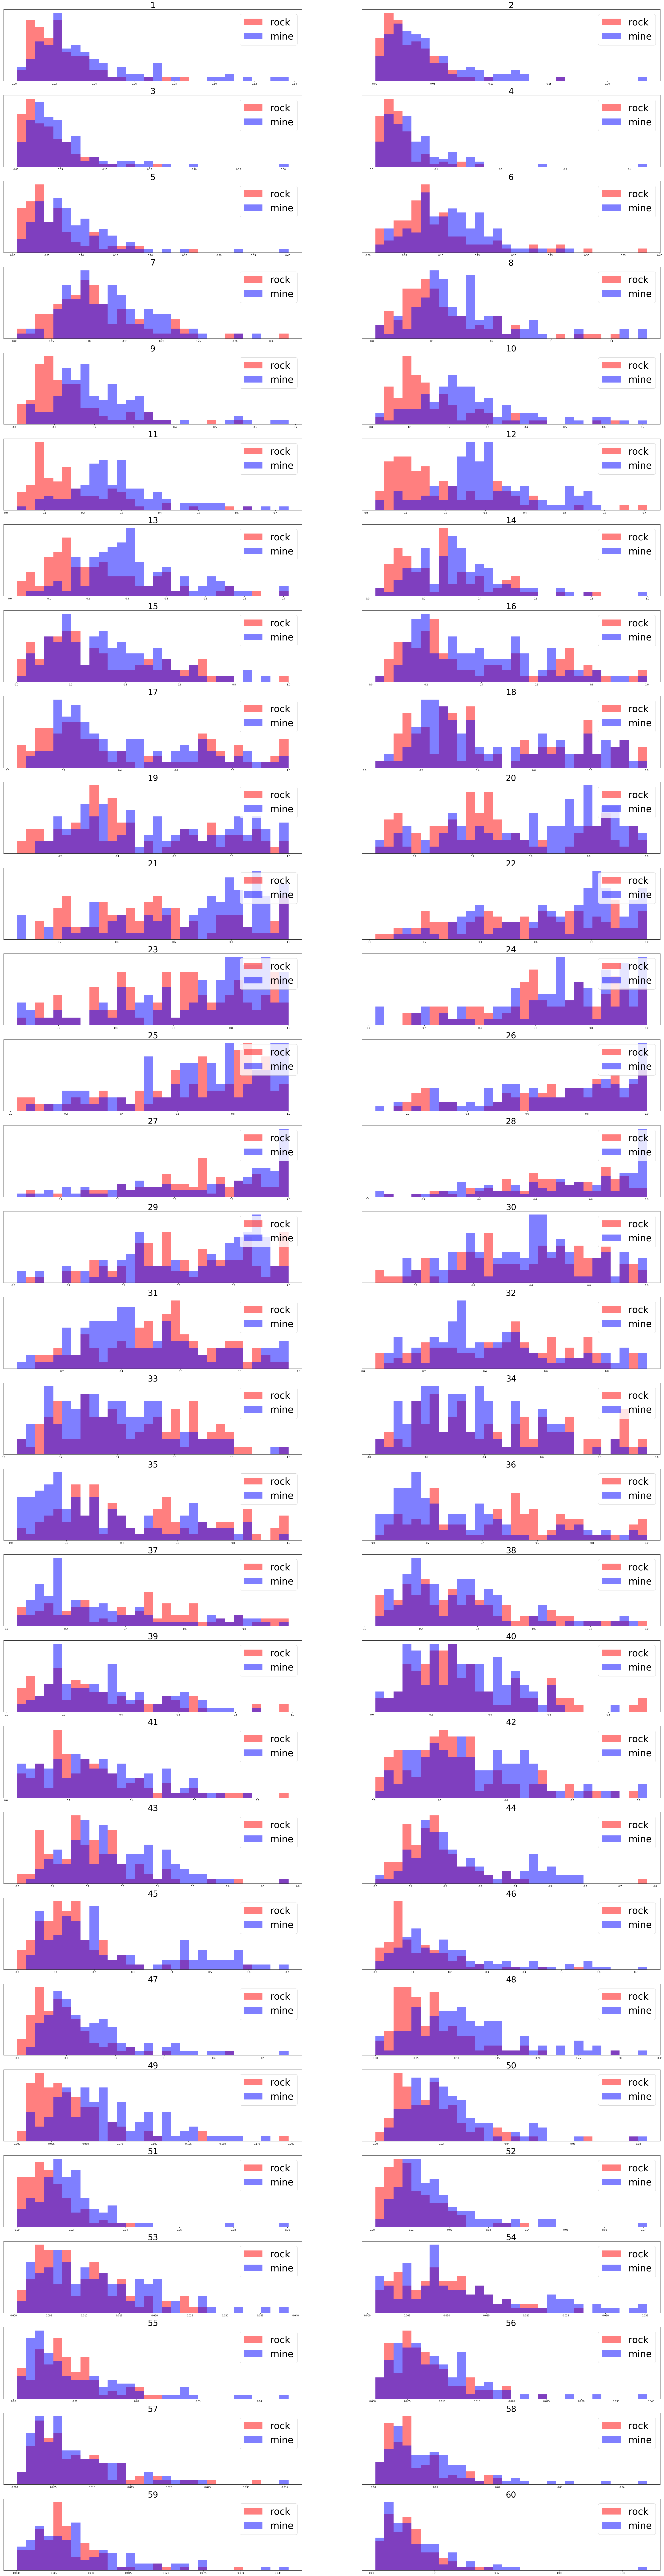

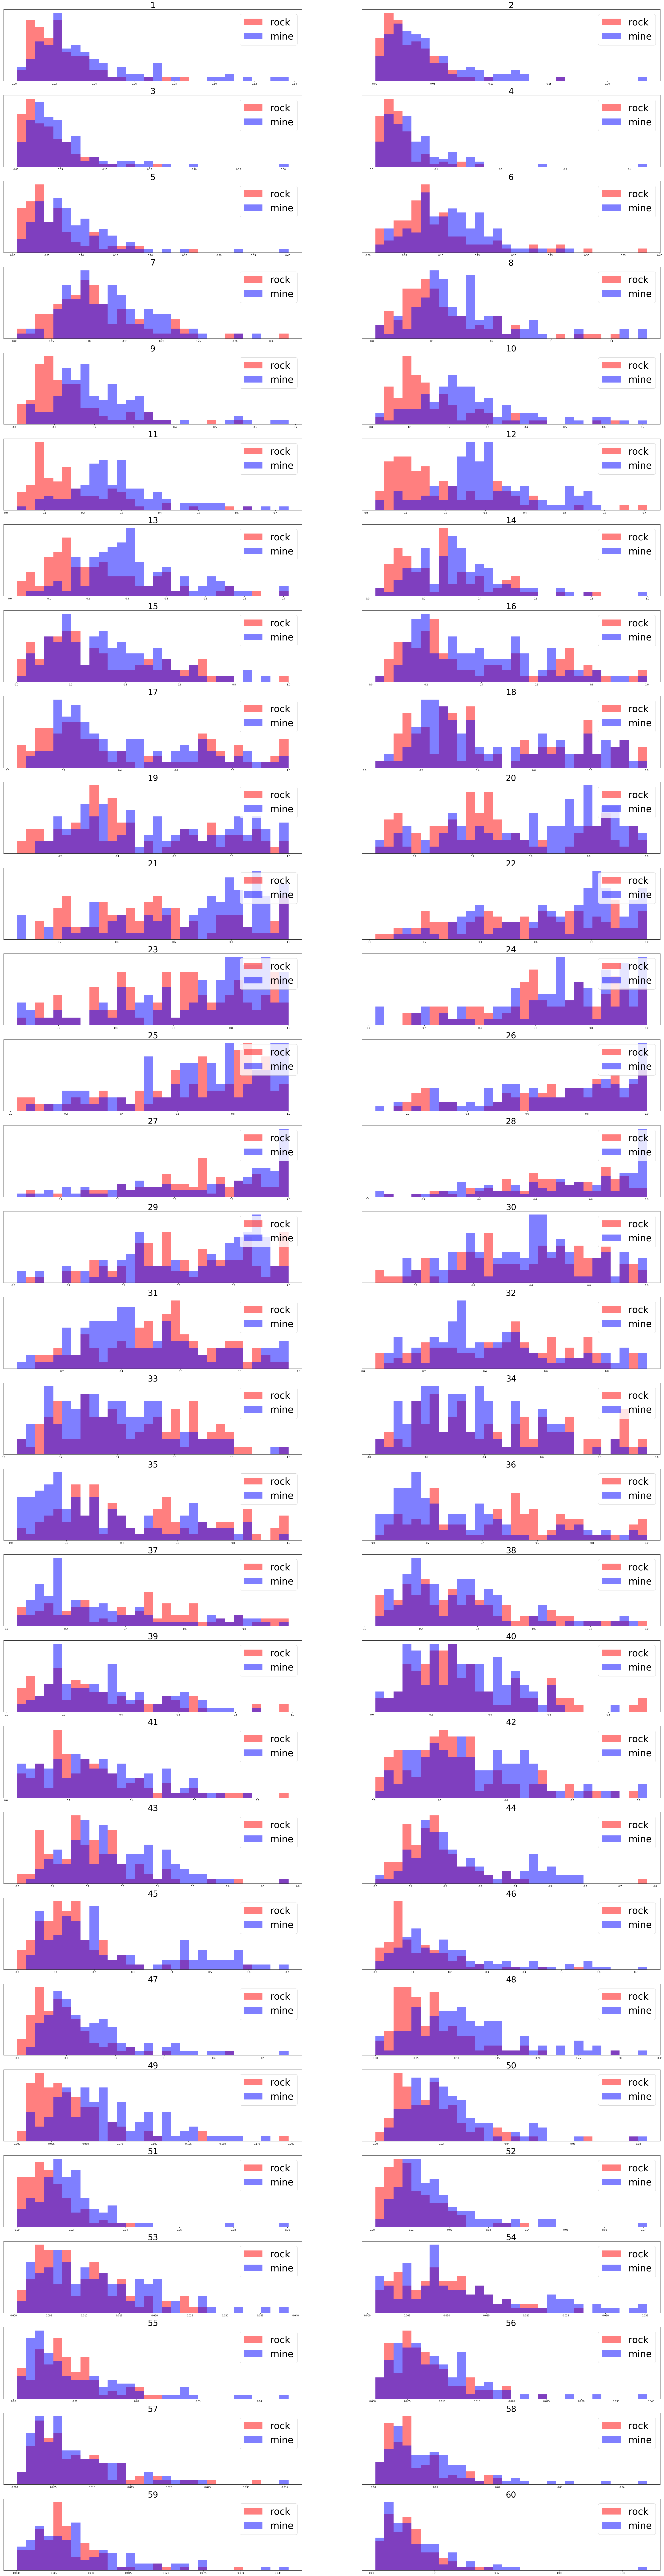

In [42]:
rock = sonar.loc[ sonar['Class'] == 'R', : ]
mine = sonar.loc[ sonar['Class'] == 'M', : ]

fig, axes = plt.subplots(30, 2, figsize=(50,200))
ax = axes.ravel() # axes are 2-dimensional so we unfold them
for i in range(60):
    _, bins = np.histogram(sonar.iloc[:,i], bins=30)
    ax[i].hist(rock.iloc[:,i], bins=bins, color='r', alpha=.5, label='rock')
    ax[i].hist(mine.iloc[:,i], bins=bins, color='b', alpha=.5, label='mine')
    ax[i].set_title(sonar.columns.values[i], fontsize=35)
    ax[i].set_yticks(()) # remove ticks on y-axis
    ax[i].legend(loc='upper right', prop={'size': 40})
fig

Primjećujemo da ne postoji značajka kojom u potpunosti možemo razdvojiti naše dvije klase.

**Korelacija** nam daje uvid u odnos numeričkih značajki. Izražava se vrijednostima između -1 i 1.
Intuitivno:
- **pozitivna** korelacija: ako se jedna značajka povećava, i druga se povećava
- **negativna** korelacija: ako se jedna značajka povećava, druga se smanjuje

Korelacija je jaka ako poprima vrijednosti blizu -1 i 1, a slaba ako su vrijednosti oko 0.

Kako bismo ju ispitali, nacrtat ćemo matricu korelacije.

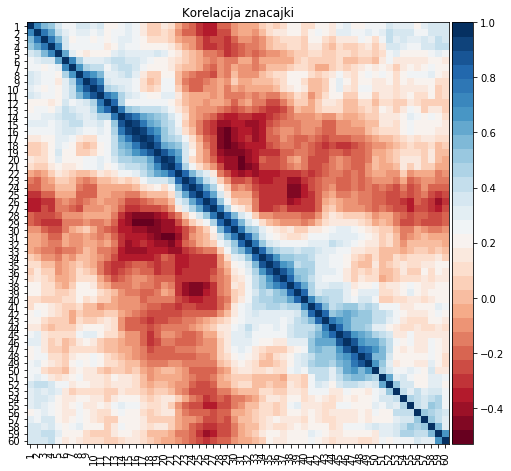

In [43]:
from matplotlib import cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable

X_corr = sonar.drop('Class',axis=1).corr()
cmap = cm.get_cmap('RdBu', 30)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
iax = ax.imshow(X_corr, interpolation="nearest", cmap=cmap)
ax.grid(False)
ax.set(title='Korelacija znacajki')
ax.set_xticks(range(X_corr.shape[1]))
ax.set_xticklabels(sonar.drop('Class',axis=1).columns.values, rotation=90)
ax.set_yticks(range(X_corr.shape[1]))
ax.set_yticklabels(sonar.drop('Class',axis=1).columns.values)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(iax,cax)

print("\n")
plt.show()

Iz ove matrice vidimo da ***nema jake koreliranosti*** među našim značajkama. Iako se na prvi pogled čini da je negativna koreliranost jaka, pogledom na skalu primjećujemo da postiže vrijednosti do najviše -0.6. Također, nema niti jake pozitivne koreliranosti.

Koreliranost je bitno utvrditi jer neki modeli strojnog učenja nisu robusni na jaku koreliranost značajki.

## 2. Smanjenje dimenzionalnosti

Odlučili smo se za smanjenje dimenzionalnosti jer nam nije bitno zadržati interpretabilnost podataka.

Interpretabilnost podataka nakon smanjenja dimenzionalnosti se gubi jer su podaci translatirani u drugi prostor pa ne možemo više znati što nam točno predstavljaju značajke koje imamo u novom prostoru. 

Koristimo **analizu glavnih komponenti (PCA)**.

**Nećemo vršiti standardizaciju** podataka prije PCA jer su nam podaci istog tipa i u istoj mjernoj jedinici.
[ref = https://www.researchgate.net/post/What_is_the_best_way_to_scale_parameters_before_running_a_Principal_Component_Analysis_PCA]

In [44]:
# Priprema podataka za daljnje korištenje

# target array (niz čiji elementi govore je li odgovarajući element tog indexa u datasetu sonar R ili M)
sonar_y = []
for i in range(97):
    sonar_y.append(0) # 0 označavaju R
for i in range(111):
    sonar_y.append(1) # 1 označavaju M
sonar_y = np.array(sonar_y)

sonar_bez_Class = sonar.drop('Class', axis=1) # uklonimo zadnji stupac Class iz sonar dataframea
sonar_X = np.array(sonar_bez_Class.values)

# sonar_y i sonar_X moraju biti np.array jer fja split prima samo objekte tog tipa

Prije provedbe PCA promiješat ćemo podatke.

In [45]:
# shuffle
from sklearn.utils import shuffle

random_state = 42
# fiksiranje broja random state omogućuje da svaki put kada opet pokrenemo ovaj kod, dobijemo istu podjelu
# ovaj broj koji fiksiramo odabran je nasumično

X,y = shuffle(sonar_X,sonar_y,random_state=random_state)
print("\nTarget varijabla nakon miješanja: \n\n", y)


Target varijabla nakon miješanja: 

 [1 0 0 0 1 0 1 1 0 1 1 0 1 1 1 1 1 1 0 0 1 1 1 1 0 0 0 0 1 1 1 0 0 1 1 1 1
 1 0 1 0 1 0 1 0 0 1 1 0 0 0 1 0 0 0 0 1 1 0 1 0 1 1 1 1 1 0 0 0 0 0 0 1 1
 0 1 1 0 0 1 0 1 0 1 1 1 0 0 0 1 1 0 0 1 0 1 0 0 1 1 0 0 1 1 0 0 1 1 1 0 0
 1 1 1 1 1 0 0 1 1 1 0 1 1 0 1 0 0 1 0 1 0 1 1 0 0 1 0 0 1 0 1 0 1 0 1 1 1
 1 0 0 0 0 1 0 0 1 1 0 0 0 0 1 1 0 0 1 1 1 1 0 0 1 0 1 1 1 0 0 0 0 0 1 1 1
 0 1 1 0 0 1 1 1 1 1 1 0 0 1 1 0 1 0 1 0 0 1 1]


### PCA

In [46]:
from sklearn.decomposition import PCA

In [47]:
#PCA

pca = PCA(.95) #  Zadržat ćemo 95% varijance.

pca.fit(X)
brojKomponenti = pca.n_components_ # Zabilježit ćemo kolika nam je nova dimenzija nakon PCA.
X = pca.transform(X)

print("\nDimenzija nakon PCA: ", brojKomponenti)


Dimenzija nakon PCA:  17


## 3. Modeli

Ranije smo spomenuli problem overfittinga na malenom datasetu. Taj problem zahtijeva odabir jednostavnijeg modela.

Uspoređivat ćemo metodu potpornih vektora (SVM), k-najbližih susjeda (k-NN) i slučajnu šumu (Random Forest). 

Prvo podijelimo dataset na 10 podskupova. Njih ćemo koristiti na sljedeći način:

za i od 1 do 10:
    - i-ti podskup je test set
    - preostalih 9 skupova tvore train set

Za svaki od 10 (train,test) parova prvo ćemo istrenirati model na train skupu pa testirati na test skupu koristeći točnost kao mjeru preciznosti.
Konačno, za svaki model izračunat ćemo prosječnu točnost na svih 10 test skupova.

Ranije smo komentirali da pri odabiru mjere preciznosti moramo obratiti pažnju na balansiranost klasa.
Naime, bla bla bla primjer
U našem slučaju, iako klase nisu u potpunosti balansirane, procjenjujemo da su dovoljno balansirane kako bi točnost bila relevantna mjera preciznosti.
Međutim, zbog male veličine dataseta, pri podjeli dataseta na podskupove preporučuje se stratifikacija kao mjera osiguranja.

**Stratifikacija** je postupak kojim osiguravamo da svaki podskup bude dobra reprezentacija cijelog skupa tako što će svaki podskup imati isti omjer mina i kamenja kao i cijeli dataset. 

In [29]:
from sklearn.model_selection import RepeatedStratifiedKFold

random_state = 164981614

rskf = RepeatedStratifiedKFold(n_splits=10, n_repeats=1, random_state=random_state)

X_train, X_test, y_train, y_test = [], [], [], []

for train_index, test_index in rskf.split(X, y):
    X_train.append(X[train_index])
    X_test.append(X[test_index])
    y_train.append(y[train_index])
    y_test.append(y[test_index])

In [30]:
print("Veličina prvog train seta: ", len(X_train[0]))
print("Veličina prvog test seta: ", len(X_test[0]))
print(len(X_train[0]), "+", len(X_test[0]), "=", len(X_train[0])+len(X_test[0]))

Veličina prvog train seta:  186
Veličina prvog test seta:  22
186 + 22 = 208


### SVM

Od mogućih izbora za kernele SVM-a koristit ćemo nelinearni kernel (RBF) zbog savjeta Andrewa Nga s Machine learning coursa na Courseri s obzirom na omjer količine featurea i veličine dataseta.

Kod SVM-a s RBF kernelom moramo prije učenja modela optimizirati dva hiperparametra: gammu i C.

Intuitivno, gamma parametar određuje koliko daleko dopire utjecaj jednog primjerka iz skupa za treniranje. Niske vrijednosti game znače "daleko", dok visko vrijednosti gamme znače "kratko". Gamma parametri mogu se promatrati kao inverz radijusa utjecaja primjera odabranih modelom kao potporni vektori.

Parametar C predstavlja trade-off pogrešne klasifikacije primjera iz seta za treniranje protiv jednostavnosti površine odlučivanja. Nizak C čini površinu odluke glatkom, dok visoki C nastoji ispravno klasificirati sve primjere iz skupa za treniranje dajući modelu slobodu odabira više uzoraka kao potpornih vektora.

Koristimo dvije metode optimizacije hiperparametara: **grid search** i **random search**.
Grid searchu zadamo za svaki parametar skup ručno odabranih vrijednosti, on isproba sve mogućnosti uređenih parova (C, gamma) te vrati najbolji.
S druge strane, random searchu zadamo raspon za svaki parametar te broj iteracija, on nasumično isprobava parove te nakon zadanog broja iteracija stane i vrati dotad najbolji nađeni par.

In [31]:
# SVM

from time import time
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn import svm
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from scipy import stats

### SVM koristeći GridSearchCV

In [32]:
pipeline = Pipeline( [ ('SVM', svm.SVC(kernel='rbf',probability=True)) ] )

parameters = {
    'SVM__C':(1.0,10.0,100.0,1000.0),
    'SVM__gamma':(0.001,0.01,0.1,1.0)
    #'SVM__C': np.logspace(-1, 3, 100),
    #'SVM__gamma': np.linspace(0.0001, 10, 100)
}

if __name__ == "__main__":
    grid_search = GridSearchCV(pipeline, parameters, cv=3)
    # default scoring je accuracy(točnost) što nam odgovara
    # zadali smo 3-fold cross-validation

    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    print(parameters)
    t0 = time()
    rjecnik = {}
    acc = []
    
    
    for i in range(10):
        grid_search.fit(X_train[i], y_train[i])
        best_parameters = grid_search.best_estimator_.get_params()
        model = grid_search.best_estimator_.fit(X_train[i], y_train[i])
        y_pred = model.predict(X_test[i])
        acc_score = accuracy_score(y_test[i],y_pred)
        acc.append(acc_score)
        conf_mat = confusion_matrix(y_test[i],y_pred)
        rjecnik[i+1] = (grid_search.best_score_, best_parameters['SVM__C'], best_parameters['SVM__gamma'], acc_score,
                       conf_mat[1][1], conf_mat[0][1], conf_mat[1][0], conf_mat[0][0])
        
        
    print("done in %0.3fs" % (time() - t0))

Performing grid search...
pipeline: ['SVM']
parameters:
{'SVM__C': (1.0, 10.0, 100.0, 1000.0), 'SVM__gamma': (0.001, 0.01, 0.1, 1.0)}
done in 3.328s


In [33]:
print("Parametri dobiveni koristeći GridSearchCV:\n")
df = pd.DataFrame(rjecnik, index=['score', 'C', 'gamma', 'accuracy', 'TP', 'FP', 'FN', 'TN'])
print(df)
    
avg_accuracy = np.average(acc)
print("\nProsječna točnost SVM-a s rbf kernelom i parametrima dobivenim koristeći GridSearchCV je:\n", 
      avg_accuracy*100, "%.")

Parametri dobiveni koristeći GridSearchCV:

                  1         2         3           4            5          6   \
score       0.860215  0.855615  0.877005    0.871658     0.866310   0.871658   
C         100.000000  1.000000  1.000000  100.000000  1000.000000  10.000000   
gamma       1.000000  1.000000  1.000000    0.100000     0.100000   1.000000   
accuracy    0.909091  0.714286  0.857143    0.809524     0.904762   0.904762   
TP         11.000000  8.000000  9.000000    9.000000    11.000000  10.000000   
FP          1.000000  3.000000  1.000000    2.000000     2.000000   1.000000   
FN          1.000000  3.000000  2.000000    2.000000     0.000000   1.000000   
TN          9.000000  7.000000  9.000000    8.000000     8.000000   9.000000   

                 7            8          9          10  
score      0.893048     0.888298   0.856383   0.893617  
C         10.000000  1000.000000  10.000000  10.000000  
gamma      1.000000     0.100000   1.000000   1.000000  
accurac

### SVM koristeći RandomizedSearchCV

In [34]:
pipeline = Pipeline( [ ('SVM', svm.SVC(kernel='rbf',probability=True)) ] )

parameters = {
    'SVM__C':stats.uniform(1, 100),
    'SVM__gamma':stats.uniform(0.001, 1.0)
}

if __name__ == "__main__":
    # multiprocessing requires the fork to happen in a __main__ protected block
    # default scoring je accuracy koji mi želimo
    randomized_search = RandomizedSearchCV(pipeline, parameters, n_iter=100, random_state=2018, cv=3)
    
    print("Performing randomized search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    t0 = time()
    rjecnik = {}
    acc = []
    for i in range(10):
        randomized_search.fit(X_train[i], y_train[i])
        best_parameters = randomized_search.best_estimator_.get_params() 
        model = randomized_search.best_estimator_.fit(X_train[i], y_train[i])
        y_pred = model.predict(X_test[i])
        acc_score = accuracy_score(y_test[i],y_pred)
        acc.append(acc_score)
        conf_mat = confusion_matrix(y_test[i],y_pred)
        rjecnik[i+1] = (randomized_search.best_score_, best_parameters['SVM__C'], best_parameters['SVM__gamma'], acc_score,
                        conf_mat[1][1], conf_mat[0][1], conf_mat[1][0], conf_mat[0][0])
        
    print("done in %0.3fs" % (time() - t0))

Performing randomized search...
pipeline: ['SVM']
done in 20.299s


In [35]:
print("Parametri dobiveni koristeći RandomizedSearchCV:\n")
df = pd.DataFrame(rjecnik, index=['score', 'C', 'gamma', 'accuracy', 'TP', 'FP', 'FN', 'TN'])
print(df)
    
avg_accuracy = np.average(acc)
print("\nProsječna točnost SVM-a s rbf kernelom i parametrima dobivenim koristeći RandomizedSearchCV je:\n", 
      avg_accuracy*100, "%.")

Parametri dobiveni koristeći RandomizedSearchCV:

                 1          2          3          4          5          6   \
score      0.865591   0.871658   0.877005   0.887701   0.871658   0.871658   
C         84.711110  14.739854  26.269136  42.686251  18.684085  76.709253   
gamma      0.698801   0.691222   0.558125   0.172810   0.580103   1.000671   
accuracy   0.954545   0.857143   0.904762   0.761905   0.952381   0.904762   
TP        11.000000  11.000000  10.000000   9.000000  11.000000  10.000000   
FP         0.000000   3.000000   1.000000   3.000000   1.000000   1.000000   
FN         1.000000   0.000000   1.000000   2.000000   0.000000   1.000000   
TN        10.000000   7.000000   9.000000   7.000000   9.000000   9.000000   

                 7          8          9          10  
score      0.893048   0.904255   0.867021   0.893617  
C         76.709253  88.424103  88.424103  76.709253  
gamma      1.000671   0.482205   0.482205   1.000671  
accuracy   0.761905   0.850

## 4. k-NN

_k Nearest Neighbor_ prima neki training set i za nove podatke određuje većinskim glasovanjem kojoj klasi pripadaju, ovisno o tome kojeg tipa je _k najbližih susjeda_. Metrika može biti bilo koja, ali uobičajena je neka od: Euklidska $(L^2)$, Manhattan $(L^1)$ i Čebišev $(L^\infty)$.

Koristili smo dodatno parameters _weights='distance'_ za tzv. težinski k-NN. Ovdje se veća važnost pridaje bližim susjedima. Tako je moguće da od 3 najbliža susjeda, 1 (jako) bliski susjed nadjača druga dva. Prilikom testiranja se pokazalo da je ovo konzistentniji algoritam (i daje nešto bolju točnost).

Dalje nalazimo koja od 3 gore navedene metrike, s kojim k između 1 i 10, je najprikladnija.

In [48]:
from sklearn.neighbors import KNeighborsClassifier
#parametar k biramo iz 1...10, i promatramo 3 metrike
parameters = {'n_neighbors': list(range(1,11)),
              'metric': ['chebyshev', 'euclidean', 'manhattan']}

if __name__ == "__main__":
    grid_search = GridSearchCV(KNeighborsClassifier(weights='distance'), parameters, cv=3)

    t0 = time()
    rjecnik = {}
    acc = []

    for i in range(10):
        grid_search.fit(X_train[i], y_train[i])
        best_parameters = grid_search.best_estimator_.get_params()
        model = grid_search.best_estimator_.fit(X_train[i], y_train[i])
        y_pred = model.predict(X_test[i])
        acc_score = accuracy_score(y_test[i],y_pred)
        acc.append(acc_score)
        conf_mat = confusion_matrix(y_test[i],y_pred)
        rjecnik[i+1] = (grid_search.best_score_, best_parameters['n_neighbors'], best_parameters['metric'], acc_score,
                       conf_mat[1][1], conf_mat[0][1], conf_mat[1][0], conf_mat[0][0])
        
    print("done in %0.3fs" % (time() - t0))

done in 2.364s


In [49]:
df = pd.DataFrame(rjecnik, index=['score', 'n_neighbors', 'metric', 'accuracy', 'TP', 'FP', 'FN', 'TN'])
print(df)

print(acc)
avg_accuracy = np.average(acc)
print("\nProsječna točnost k-NN-a koristeći najbolju metriku je:\n", 
      avg_accuracy*100, "%.")

                    1          2          3          4          5          6   \
score         0.822581   0.828877   0.850267   0.850267   0.850267   0.839572   
n_neighbors          1          1          1          1          3          3   
metric       chebyshev  chebyshev  chebyshev  chebyshev  euclidean  chebyshev   
accuracy      0.954545   0.904762   0.809524   0.857143   0.857143   0.857143   
TP                  11         10          9         11         10          9   
FP                   0          1          2          3          2          1   
FN                   1          1          2          0          1          2   
TN                  10          9          8          7          8          9   

                    7          8          9          10  
score         0.855615    0.87766   0.829787   0.861702  
n_neighbors          3          3          5          1  
metric       euclidean  chebyshev  chebyshev  chebyshev  
accuracy      0.619048        0.8     

## 5. Random Forest

Random Forest je primjer ansambl metode. Ansambli su više klasifikatora spojenih u jedan bolji.
Glavni parametri u Random Forest su broj stabala *n_estimators* i broj korištenih feature-a u svakom stablu *max_features*.

Trenira se *n_estimators* stabala odlučivanja na nekom podskupu značajki. Bira se slučajno *max_features* značajki. Kako smo smanjili dimenzije na 17 s PCA, ovdje ima smisla uzimati do 17 značajki.

Radi brzine, kod *n_estimators* smo birali svaki drugi.

In [42]:
from sklearn.ensemble import RandomForestClassifier

# biramo broj stabala odlučivanja u šumi te broj značajki koje će Random Forest algoritam koristiti
parameters = {'n_estimators': list(range(1,21,2)),
              'max_features': list(range(1,18))}
print("Parameter grid:\n{}",format(parameters))

if __name__ == "__main__":
    # multiprocessing requires the fork to happen in a __main__ protected block
    # default scoring je accuracy koji mi želimo
    grid_search = GridSearchCV(RandomForestClassifier(random_state=2018), parameters, cv=3)

    t0 = time()
    rjecnik = {}
    acc = []

    for i in range(10):
        grid_search.fit(X_train[i], y_train[i])
        best_parameters = grid_search.best_estimator_.get_params()
        model = grid_search.best_estimator_.fit(X_train[i], y_train[i])
        y_pred = model.predict(X_test[i])
        acc_score = accuracy_score(y_test[i],y_pred)
        acc.append(acc_score)
        conf_mat = confusion_matrix(y_test[i],y_pred)
        rjecnik[i+1] = (grid_search.best_score_, best_parameters['n_estimators'], best_parameters['max_features'], acc_score,
                       conf_mat[1][1], conf_mat[0][1], conf_mat[1][0], conf_mat[0][0])
        
    print("done in %0.3fs" % (time() - t0))

Parameter grid:
{} {'n_estimators': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19], 'max_features': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]}
done in 74.896s


In [45]:
df = pd.DataFrame(rjecnik, index=['score', 'n_estimators', 'max_features', 'accuracy', 'TP', 'FP', 'FN', 'TN'])
print(df)

print(acc)
avg_accuracy = np.average(acc)
print("\nProsječna točnost RandomForest:\n", 
      avg_accuracy*100, "%.")

                    1          2          3          4          5          6   \
score         0.779570   0.791444   0.786096   0.802139   0.807487   0.796791   
n_estimators  9.000000  15.000000  15.000000   7.000000  15.000000  13.000000   
max_features  9.000000  13.000000  14.000000  12.000000   3.000000  15.000000   
accuracy      0.818182   0.761905   0.809524   0.761905   0.761905   0.809524   
TP            9.000000   9.000000   8.000000  10.000000   9.000000   9.000000   
FP            1.000000   3.000000   1.000000   4.000000   3.000000   2.000000   
FN            3.000000   2.000000   3.000000   1.000000   2.000000   2.000000   
TN            9.000000   7.000000   9.000000   6.000000   7.000000   8.000000   

                     7         8         9          10  
score          0.786096  0.792553  0.787234   0.819149  
n_estimators  19.000000  7.000000  7.000000  15.000000  
max_features   6.000000  8.000000  7.000000  12.000000  
accuracy       0.857143  0.700000  0.85000